# Mod 4 Project - Starter Notebook

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
# Import necessary functions

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose


In [2]:
df = pd.read_csv('data/zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


In [4]:
df.shape

(14723, 272)

In [5]:
df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,191100.0,192400.0,193700.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400


### Filtering for 5-digit Zipcodes

In [6]:
df['RegionName'] = df['RegionName'].map("{:05}".format)
df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,58333,01338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,59107,03293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,191100.0,192400.0,193700.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400


#### 

In [7]:
df['RegionName'] = df['RegionName'].astype(str).str.zfill(5)

In [8]:
df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,58333,01338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,59107,03293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,191100.0,192400.0,193700.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400


# Queens, NY County Test

In [28]:
queens = df[df['CountyName'] == 'Queens']
queens

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
12,62087,11375,New York,NY,New York,Queens,13,252400.0,251800.0,251400.0,...,1022600,1033700,1048600,1066400,1081200,1088800,1092700,1089500,1084000,1084600
85,62088,11377,New York,NY,New York,Queens,86,179000.0,178900.0,179000.0,...,736400,739100,741900,745700,749100,749900,750300,753000,758200,762500
99,62067,11355,New York,NY,New York,Queens,100,182800.0,182500.0,182300.0,...,842400,847300,853000,859500,865500,871400,875900,877300,882400,890200
138,62093,11385,New York,NY,New York,Queens,139,160600.0,160900.0,161300.0,...,623300,626100,629600,631300,631700,634200,639700,644700,651000,657500
140,62085,11373,New York,NY,New York,Queens,141,175400.0,175800.0,176400.0,...,743700,747200,754600,759800,762500,766900,773700,776100,775900,777000
228,62084,11372,New York,NY,New York,Queens,229,190200.0,190800.0,191700.0,...,840100,845700,849300,849700,849400,845900,841900,848800,860100,861800
407,62080,11368,New York,NY,New York,Queens,408,160700.0,160900.0,161100.0,...,695400,699300,705700,710300,714800,720700,727100,731400,734100,735400
552,62066,11354,New York,NY,New York,Queens,553,225300.0,226500.0,227800.0,...,872100,880900,892400,903100,911000,916500,923500,929900,935700,941200
630,62086,11374,New York,NY,New York,Queens,631,215400.0,215600.0,215900.0,...,799900,802300,805200,808400,812300,817100,822600,827900,834200,839600
743,62120,11434,New York,NY,New York,Queens,744,132900.0,132800.0,132800.0,...,400100,402500,404300,406200,408100,409500,410100,410600,412500,415400


# Step 2: Data Preprocessing

In [9]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[7:], format='%Y-%m')

In [29]:
get_datetimes(queens)

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

In [30]:
# checking total number of zip codes
print(f'There are {df.RegionName.nunique()} different zip codes in our dataset.')

There are 14723 different zip codes in our dataset.


# Step 4: Reshape from Wide to Long Format

In [12]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [32]:
queens_ts = melt_data(queens)
display(ts.head(10))
display(ts.info())

,value
time,
1996-04-01,118299.123063
1996-05-01,118419.044139
1996-06-01,118537.423268
1996-07-01,118653.069278
1996-08-01,118780.254312
1996-09-01,118927.528500
1996-10-01,119120.520316
1996-11-01,119345.352236
1996-12-01,119685.084771


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 265 entries, 1996-04-01 to 2018-04-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   265 non-null    float64
dtypes: float64(1)
memory usage: 4.1 KB


None

In [34]:
#melt the dataset
queens_melted_long = pd.melt(queens, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')

#change to datetime dataframe
queens_melted_long['time'] = pd.to_datetime(queens_melted_long['time'], infer_datetime_format=True)

#set to datetime index
queens_melted_long = queens_melted_long.set_index('time')

queens_melted_long

,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,value
time,,,,,,,,
1996-04-01,11375,62087,13,New York,NY,New York,Queens,252400.0
1996-04-01,11377,62088,86,New York,NY,New York,Queens,179000.0
1996-04-01,11355,62067,100,New York,NY,New York,Queens,182800.0
1996-04-01,11385,62093,139,New York,NY,New York,Queens,160600.0
1996-04-01,11373,62085,141,New York,NY,New York,Queens,175400.0
...,...,...,...,...,...,...,...,...
2018-04-01,11004,61979,7725,New York,NY,New York,Queens,634300.0
2018-04-01,11416,62102,8008,New York,NY,New York,Queens,517300.0
2018-04-01,11436,62122,8009,New York,NY,New York,Queens,400300.0


In [35]:
#check for nulls
queens_melted_long.isna().sum()

RegionName      0
RegionID        0
SizeRank        0
City            0
State           0
Metro           0
CountyName      0
value         189
dtype: int64

In [36]:
#rename the zipcode column with appropriate name
queens_melted_long = queens_melted_long.rename(columns={'RegionName': 'ZipCode'})

#drop unique region ID column
queens_melted_long = queens_melted_long.drop('RegionID', axis=1)

queens_melted_long

,ZipCode,SizeRank,City,State,Metro,CountyName,value
time,,,,,,,
1996-04-01,11375,13,New York,NY,New York,Queens,252400.0
1996-04-01,11377,86,New York,NY,New York,Queens,179000.0
1996-04-01,11355,100,New York,NY,New York,Queens,182800.0
1996-04-01,11385,139,New York,NY,New York,Queens,160600.0
1996-04-01,11373,141,New York,NY,New York,Queens,175400.0
...,...,...,...,...,...,...,...
2018-04-01,11004,7725,New York,NY,New York,Queens,634300.0
2018-04-01,11416,8008,New York,NY,New York,Queens,517300.0
2018-04-01,11436,8009,New York,NY,New York,Queens,400300.0


# Step 3: EDA and Visualization

In [17]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

Let's see the median housing sales values of homes within Queens over time in general.

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


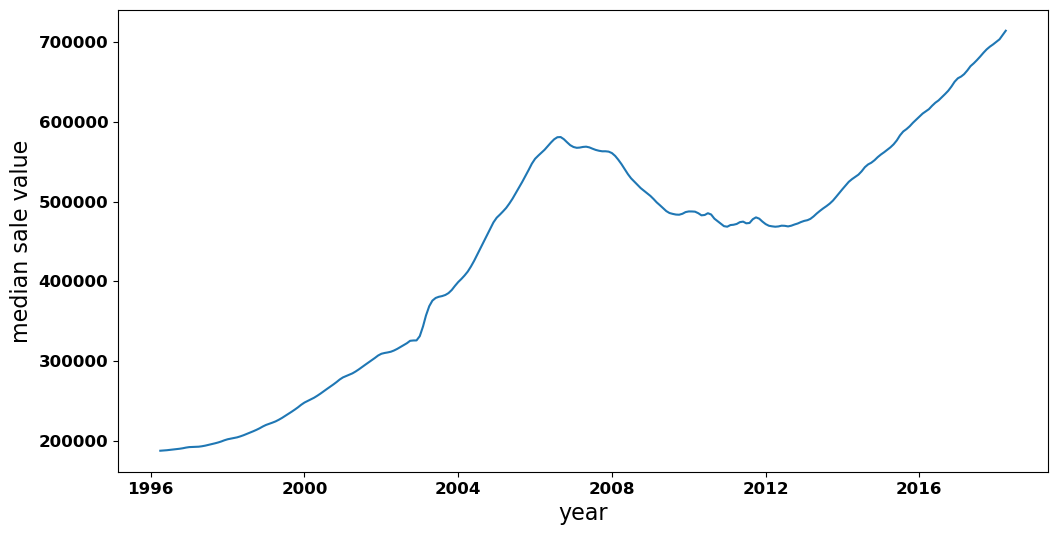

In [37]:
fig = plt.figure(figsize=(12, 6))
plt.plot(queens_ts)
plt.xlabel("year", fontsize=16)
plt.ylabel("median sale value", fontsize=16)
plt.show();

Let's get a view of the median housing sales values over time for each zipcode.

In [38]:
plt.figure(figsize=(12,8))
for zipcode in queens_melted_long.RegionName.unique():
    queens_melted_long.loc[queens_melted_long['RegionName'] == zipcode].value.plot(label=zipcode)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=2)
plt.show();

AttributeError: 'DataFrame' object has no attribute 'RegionName'

<Figure size 1200x800 with 0 Axes>

It looks like every zipcode within the county is following a very similar trend even though they have varying sales values.

## Dickey-Fuller Test

Both graphs show an upwards trend so it may not be stationary. Let's use the Dickey Fuller test to double check.

In [24]:
#queenstest = adfuller(queens_ts)
#display(queenstest)

In [25]:
# Dickey Fuller Text
queenstest = adfuller(queens_ts)

dfoutput = pd.Series(
                queenstest[0:4], 
                index=['Test Statistic','p-value','#Lags Used','Number of Observations Used']
)

for key,value in queenstest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
display(dfoutput)

NameError: name 'queens_ts' is not defined

The p-value is 0.616. Since it's quite a large number compared to an alpha value of 0.05, it can be concluded that this is not stationary.

In [26]:
queens_test = adfuller(queens_ts)[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {queens_test},")
if queens_test < 0.05:
    print(" therefore we can safely assume that the dataset is stationary.")
else:
    print(" therefore we cannot reject the null hypothesis that the dataset is \
not stationary.")

NameError: name 'queens_ts' is not defined

In [27]:
queens_ts

NameError: name 'queens_ts' is not defined

In [ ]:
index = pd.DatetimeIndex(get_datetimes(queens))
index

In [ ]:
queens_ts

# Stationarity Tests
Before we proceed with our forecasting model, we first have to make sure that our dataset is stationary. 

In [ ]:
fig = plt.figure(figsize=(12, 10))


# No transformation
plt.subplot(3, 1, 1)
plt.plot(queens_ts)
plt.xlabel("month", fontsize=16)
plt.ylabel("monthly sales", fontsize=16)

# Log transformation (linear and heteroscedastic)
plt.subplot(3, 1, 2)
plt.plot(pd.Series(np.log(queens_ts['value']), index=index), color="blue") #log transformation with np.log()
plt.xlabel("month", fontsize=14)
plt.ylabel("log(monthly sales)", fontsize=14)

# Square root transformation 
plt.subplot(3, 1, 3)
plt.plot(pd.Series(np.sqrt(queens_ts['value']), index=index), color="green") #sqrt transformation with np.sqrt()
plt.xlabel("month", fontsize=14)
plt.ylabel("sqrt(monthly sales)", fontsize=14)


plt.show()

### Log Transformation

In [ ]:
#Log Transformation
log_q = pd.Series(np.log(queens_ts['value']))

log_test = adfuller(log_q)[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {log_test},")
if log_test < 0.05:
    print(" therefore we can safely assume that the log transformed data is stationary.")
else:
    print(" therefore we cannot reject the null hypothesis that the log transformed data is \
not stationary.")

### Square Root Transformation

In [ ]:
#Square Root Transformation
sqrt_q = pd.Series(np.sqrt(queens_ts['value']))

sqrt_test = adfuller(sqrt_q)[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {sqrt_test},")
if sqrt_test < 0.05:
    print(" therefore we can safely assume that the square root transformed data is stationary.")
else:
    print(" therefore we cannot reject the null hypothesis that the square root transformed data is \
not stationary.")

### Substracting the Rolling Mean

#### Rolling Statistics

In [ ]:
rolmean = queens_ts.rolling(window=6, center=False).mean() #rolling mean of 6 months --> call rolling function and do .mean()
rolstd = queens_ts.rolling(window=1, center=False).std() #rolling std of 1 month --> call rolling function and do .std()

fig = plt.figure(figsize=(12, 7))
orig = plt.plot(queens_ts, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

#### Using the Rolling Mean to Subtract from Time Series

In [ ]:
# Start with the log transform
data_transform = pd.Series(np.log(queens_ts['value']))

rolmean = data_transform.rolling(window=4).mean()
fig = plt.figure(figsize=(11, 7))
orig = plt.plot(data_transform, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [ ]:
# Subtract the moving average from the original data and check head for Nans
data_minus_rolmean = data_transform - rolmean
data_minus_rolmean.head()

In [ ]:
# Drop the NaN values from timeseries calculated above 
# (the first few values didn't have a rolling mean)
data_minus_rolmean.dropna(inplace=True)
data_minus_rolmean

In [ ]:
fig = plt.figure(figsize=(11, 7))
plt.plot(data_minus_rolmean, label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Sales while the rolling mean is subtracted')
plt.show(block=False)

In [ ]:
# Print Dickey-Fuller test results
print ('Results of Dickey-Fuller Test:')

dfoutput = pd.Series(dftest[0:4],
                     index=['Test Statistic', 'p-value', '#Lags Used',
                            'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

In [ ]:
rm_test = adfuller(data_minus_rolmean)[1]

print(f"The p-value associated with the Dickey-Fuller statistical test is {rm_test},")
if rm_test < 0.05:
    print(" therefore we can safely assume that subtracted rolling mean data is stationary.")
else:
    print(" therefore we cannot reject the null hypothesis that subtracted rolling mean data is \
not stationary.")

### Differencing

In [ ]:
diff = queens_ts.diff().dropna()

In [ ]:
pd.DataFrame(np.hstack((queens_ts[1:].values.reshape(-1, 1),
                        diff.values.reshape(-1, 1))), columns=['orig', 'diff'])

In [ ]:
diff.plot();

In [ ]:
p_val = adfuller(diff)[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {p_val},")
if p_val < 0.05:
    print(" therefore we can safely assume that the differenced data is stationary.")
else:
    print(" therefore we cannot reject the null hypothesis that the differenced data is \
not stationary.")

## Time Series Decomposition

#### Method 1

In [ ]:
fig = plt.figure(figsize=(12, 20))

# Apply decomposition to separate the time series into trend, seasonal, and residual components
decomp = seasonal_decompose(queens_ts, model='additive', period=12) # Change period according to seasonality

# Plot the original time series and the decomposed components
plt.subplot(4, 1, 1)
plt.plot(queens_ts)
plt.title('Original Time Series')

plt.subplot(4, 1, 2)
plt.plot(decomp.trend)
plt.title('Trend Component')

plt.subplot(4, 1, 3)
plt.plot(decomp.seasonal)
plt.title('Seasonal Component')

plt.subplot(4, 1, 4)
plt.plot(decomp.resid)
plt.title('Residual Component')

# Apply different transformations to each component
trend_transformed = np.log(decomp.trend)
seasonal_transformed = np.diff(decomp.seasonal, n=1)
residual_transformed = np.sqrt(decomp.resid)

# Plot the transformed components
plt.figure()
plt.subplot(3, 1, 1)
plt.plot(trend_transformed)
plt.title('Log-Transformed Trend Component')

plt.subplot(3, 1, 2)
plt.plot(seasonal_transformed)
plt.title('Differenced Seasonal Component')

plt.subplot(3, 1, 3)
plt.plot(residual_transformed)
plt.title('Square Root-Transformed Residual Component')

plt.show()


In [ ]:
#Differenced Seasonal Component Transformation
dst_q = pd.Series(seasonal_transformed)

dst_test = adfuller(dst_q)[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {dst_test},")
if dst_test < 0.05:
    print(" therefore we can safely assume that the square root transformed data is stationary.")
else:
    print(" therefore we cannot reject the null hypothesis that the square root transformed data is \
not stationary.")

In [ ]:
dst_test = adfuller(dst_q)
dst_test

#### Method 2

In [ ]:
# Using log transformation as it decreased the p-value the most of the previous transformations
decomposition = seasonal_decompose(np.log(queens_ts))

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [ ]:
# Plot gathered statistics
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(np.log(queens_ts), label='Original')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()

In [ ]:
# Drop NaN values from residuals.
ts_log_decompose = residual
ts_log_decompose = ts_log_decompose.dropna()

In [ ]:
# Print Dickey-Fuller test results
dftest = adfuller(ts_log_decompose)

print ('Results of Dickey-Fuller Test:')

dfoutput = pd.Series(dftest[0:4],
                     index=['Test Statistic', 'p-value', '#Lags Used',
                            'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

In [ ]:
#Differenced Seasonal Component Transformation

dftest = adfuller(ts_log_decompose)[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {dftest},")
if dftest < 0.05:
    print(" therefore we can safely assume that the seasonally differenced data is stationary.")
else:
    print(" therefore we cannot reject the null hypothesis that the seasonally differenced data is \
not stationary.")

In [ ]:
ts_log_decompose.plot();

## Train Test Split

In [ ]:
# find the index which allows us to split off 20% of the data
cutoff = round(queens_ts.shape[0]*0.8) #cut off point at 80% of the data
cutoff

In [ ]:
# Define train and test sets according to the index found above
train = queens_ts[:cutoff] #before cut off is train set -- 80%

test = queens_ts[cutoff:] #after cut off is the test set --20%

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend();

# TimeSeriesSplit ? 

In [ ]:
split = TimeSeriesSplit()


## Baseline Model

The baseline model has just one time period shift in our dataset.

In [ ]:
train

In [ ]:
test

In [ ]:
# we can perform this with the shift operator
# The prediction for the next day is the original series shifted to the future by one day.
naive = train.shift(1)
naive

Let's take a look at a shift of one time period over.

In [ ]:
fig, ax = plt.subplots()

train.plot(ax=ax, c='r', label='original')
naive.plot(ax=ax, c='b', label='shifted')
ax.set_title('naive')
ax.legend();

In [ ]:
#A closer look
fig, ax = plt.subplots()

train[0:30].plot(ax=ax, c='r', label='original')
naive[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('naive')
ax.legend();

For a baseline to compare our later models, lets calculate our RMSE for the naive model.

In [ ]:
np.sqrt(mean_squared_error(train[1:], naive.dropna()))

In [ ]:
fig, ax = plt.subplots()
residuals = naive[1:] - train[1:] #shift minus the train
ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(30).std());

In [ ]:
fig, ax = plt.subplots()

ax.plot(residuals.index, residuals.rolling(30).var());

In [ ]:
fig, ax = plt.subplots()
ax.plot(train.diff())  #taking the differnce
ax.set_title('Monthly differenced data');

In [ ]:
p_val = adfuller(train.diff()[1:])[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {p_val},")
if p_val < 0.05:
    print(" therefore we can safely assume that the differenced data is stationary.")
else:
    print(" therefore we cannot reject the null hypothesis that the differenced data is \
not stationary.")

# Step 5: ARIMA Modeling

In [ ]:
#Plot_acf is used to identify the q parameter
plot_acf(train)

check q -- 19, 20, 21

In [ ]:
##plot_acf is used to identify the p parameter 
plot_pacf(train)

check p parameter value of 2 and 3 

# FOR ARIMA MODEL
p = 2, 3
d = 0
q = 20, 21

## Autoregressive Model (AR)

In [ ]:
ar_1 = ARIMA(train, order=(2, 1, 20)).fit()

# We put a typ='levels' to convert our predictions to remove the differencing performed.
ar_1.predict(typ='levels')

In [ ]:
ar_1.summary()

In [ ]:
ar_1.aic

## Random Walk

In [ ]:
random_walk_model = ARIMA(train, order=(0, 1, 0)).fit() #random walk model - making it stationary by taking difference 
random_walk_model.summary()

In [ ]:
print(f'Random Walk AIC: {random_walk_model.aic}')
print(f'AR(1, 1, 0) AIC: {ar_1.aic}' )

#### RMSE: Random Walk vs AR1

In [ ]:
y_hat_ar1 = ar_1.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ar1)) #ar1 RMSE

In [ ]:
y_hat_rw = random_walk_model.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_rw)) #random walk RMSE

The random walk model has a higher RMSE, therefore, it performed worse.

# Step 6: Interpreting Results

In [46]:
queens_zip_median

,SizeRank,value
ZipCode,,
11004,7725.0,480900.0
11101,1300.0,650800.0
11102,2044.0,554200.0
11103,1932.0,551100.0
11104,3199.0,533500.0
11105,2791.0,556200.0
11354,553.0,606700.0
11355,100.0,527300.0
11356,6555.0,462200.0


In [ ]:
queens_melted_long

# Other Graphs

In [47]:
#Calculate the Median Sales Value Grouped By Zipcode 
queens_zip_median = queens_melted_long.groupby('ZipCode').median()

#Sort Descending by Value and fixate on top 10 only
top10 = queens_zip_median.sort_values(by='value', ascending=False)[:10]

#drop non relevant rows
top10 = top10.drop('SizeRank', axis=1)
top10

,value
ZipCode,
11363,818400.0
11694,724500.0
11360,710500.0
11362,679700.0
11375,675000.0
11101,650800.0
11364,619600.0
11357,611700.0
11415,609600.0


In [49]:
#Calculate the Mean Sales Value Grouped By Zipcode 
queens_zip_mean = queens_melted_long.groupby('ZipCode').mean()

#Sort Descending by Value and fixate on top 10 only
top10_mean = queens_zip_mean.sort_values(by='value', ascending=False)[:10]

#drop non relevant rows
top10_mean = top10_mean.drop('SizeRank', axis=1)
top10_mean

,value
ZipCode,
11363,735301.132075
11694,663121.509434
11360,656026.415094
11101,621317.105263
11362,615289.811321
11375,608116.981132
11415,569556.981132
11364,565133.962264
11357,556736.603774


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


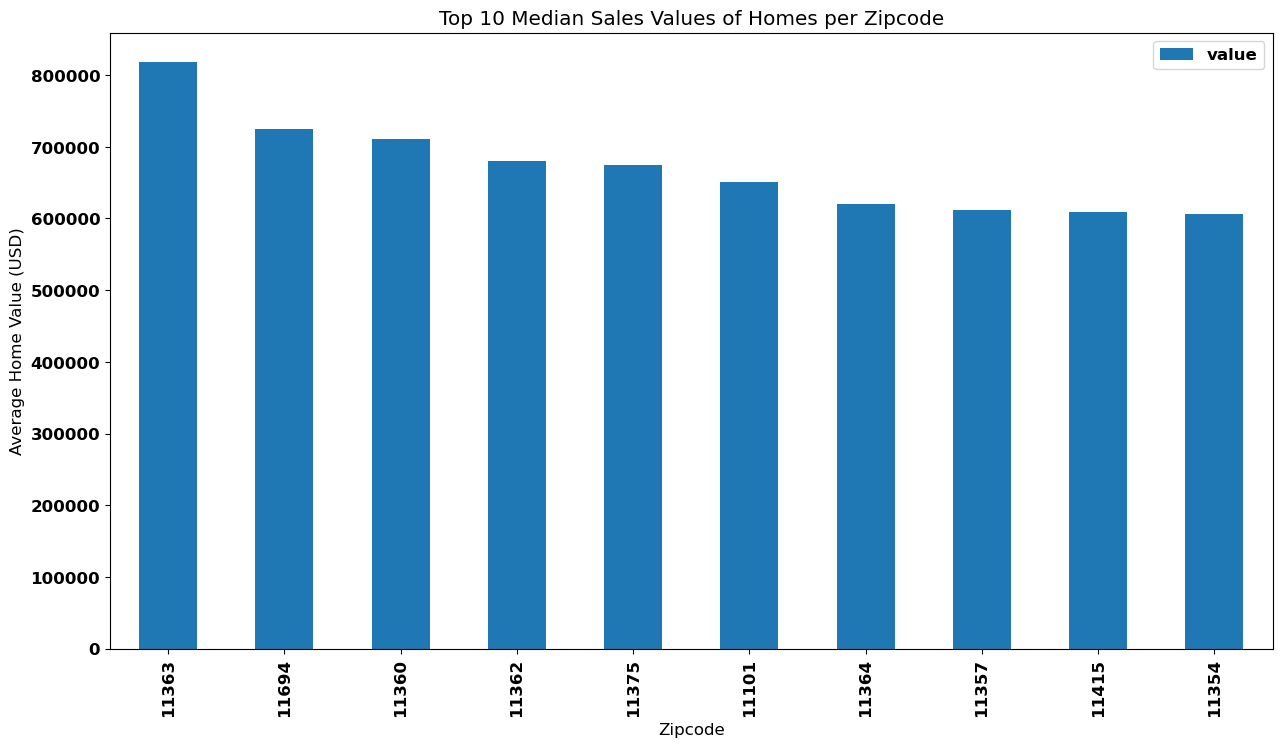

In [50]:
top10.plot(kind='bar',figsize=(15,8))
plt.title("Top 10 Median Sales Values of Homes per Zipcode")
plt.xlabel("Zipcode")
plt.ylabel("Average Home Value (USD)")
plt.plot();

In [51]:
top10_zips = 11363, 11694, 11360, 11101, 11362, 11375, 11415, 11364, 11357, 11354

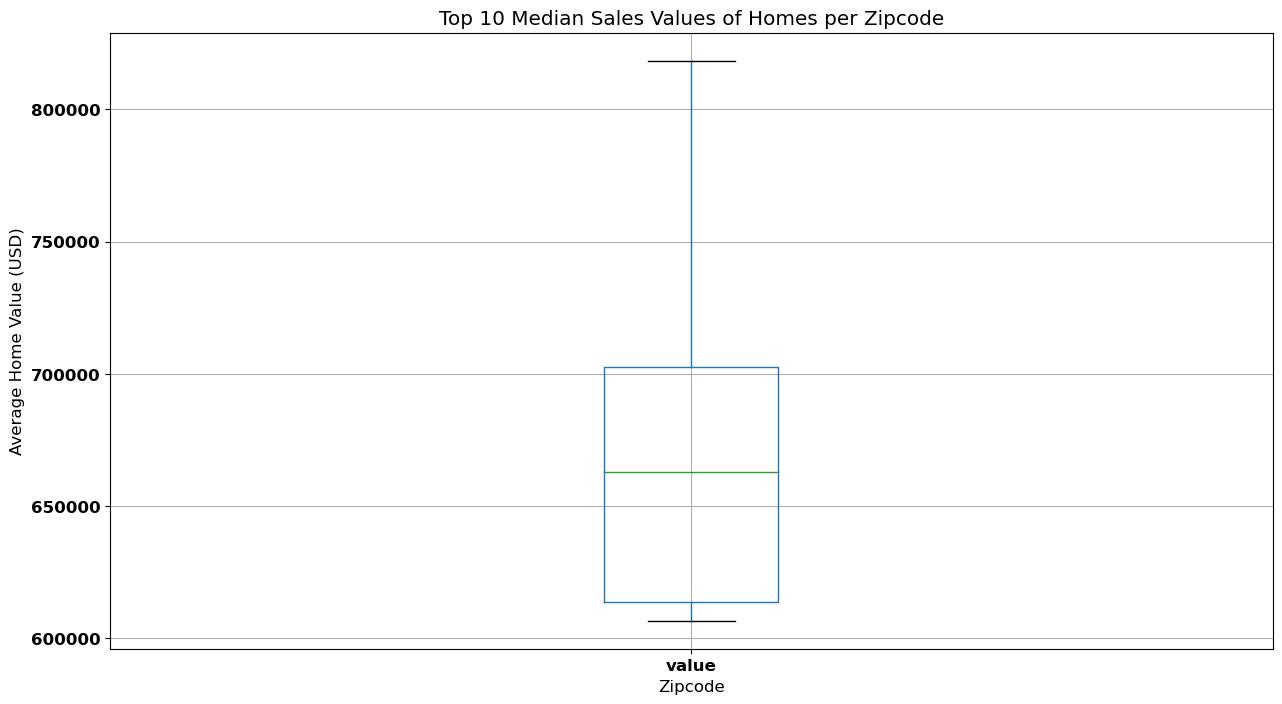

In [52]:
top10.boxplot(figsize=(15,8))
plt.title("Top 10 Median Sales Values of Homes per Zipcode")
plt.xlabel("Zipcode")
plt.ylabel("Average Home Value (USD)")
plt.plot();